# Novelty detection using 1-class SVM

Classifies new data as similar or different to the training set.  This method is an unsupervised method that builds a decision boundary between the data and origin in kernel space and can be used as a novelty detector.

In [38]:
# Setup
%load_ext sql
# %sql postgresql://gpdbchina@10.194.10.68:55000/madlib
%sql postgresql://fmcquillan@localhost:5432/madlib
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.font_manager

The sql extension is already loaded. To reload it, use:
  %reload_ext sql


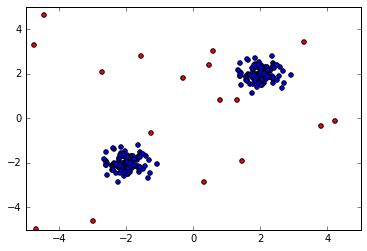

In [39]:
# Generate train data
X = 0.3 * np.random.randn(100, 2)
X_train = np.r_[X + 2, X - 2]
X_train_D = pd.DataFrame(X_train, columns=['x1', 'x2'])

# Generate some abnormal novel observations
X_outliers = np.random.uniform(low=-7, high=7, size=(40, 2))
X_outliers_D = pd.DataFrame(X_outliers, columns=['x1', 'x2'])

b = plt.scatter(X_train[:, 0], X_train[:, 1], c='blue')
c = plt.scatter(X_outliers[:, 0], X_outliers[:, 1], c='red')
plt.axis('tight')
plt.xlim((-5, 5))
plt.ylim((-5, 5))
plt.show()

In [40]:
# Build tables
%sql DROP TABLE IF EXISTS X_train_D CASCADE
%sql PERSIST X_train_D
%sql ALTER TABLE X_train_D add column X float[]
%sql update X_train_D set X = array[x1, x2]::float[]

%sql DROP TABLE IF EXISTS X_outliers_D CASCADE
%sql PERSIST X_outliers_D
%sql ALTER TABLE X_outliers_D add column X float[]
%sql update X_outliers_D set X = array[x1, x2]::float[]

Done.
Done.
200 rows affected.
Done.
Done.
40 rows affected.


[]

In [41]:
%%sql 
-- Train the model
DROP TABLE IF EXISTS svm_out1, svm_out1_summary, svm_out1_random CASCADE;
SELECT madlib.svm_one_class(
    'X_train_D',    -- source table
    'svm_out1',     -- output table
    'X',            -- features
    'gaussian',     -- kernel
    'gamma=1, n_components=55, random_state=3', 
    NULL,           -- grouping 
    'init_stepsize=0.1, lambda=10, max_iter=100, tolerance=0'  
    );
SELECT * FROM svm_out1; 

Done.
1 rows affected.
1 rows affected.


coef,loss,norm_of_gradient,num_iterations,num_rows_processed,num_rows_skipped,dep_var_mapping
"[-0.0464306799936, -0.140449420067, -0.764612793969, 0.0561685540245, -0.252354327958, 0.0495049204882, 0.391554812087, -0.703309532619, 0.368742803259, -0.930454424768, 0.491168162198, -0.0386557437811, -0.140089009113, -0.069960677275, -0.0591263658714, -0.739785078271, -0.0294268532071, -0.908443499292, -0.670068256829, -0.585115814628, -0.127288150455, -0.132263939273, -0.63193927756, -0.267746761158, -0.308319881721, -0.112196082983, 0.314925255979, 0.489853397793, 0.558233085441, -0.317663291248, -0.0283645416631, 0.351683891295, 0.0420027146589, 0.598375924694, 0.440495824996, 0.32693078572, 0.0826075162544, -0.0926654621441, -0.608400366479, -0.103107469427, 0.625755815962, 0.111294051421, 0.503191159649, 0.561639019968, 0.146793229579, 0.343509390648, -0.0539117933362, 0.111156536713, 0.696593342258, 0.749628460803, -0.245320818382, -0.126394405676, 0.330116990245, -0.292737229582, -0.471647870958, -1.00004273785]",81.1574633093,113.632707563,100,201,-1,"[-1.0, 1.0]"


In [43]:
# Prediction
# First for the training data
%sql drop table if exists y_pred_train;
%sql SELECT madlib.svm_predict('svm_out1', 'X_train_D', 'index', 'y_pred_train');
y_pred_train = %sql SELECT * from y_pred_train; 

# Next for the outliers
%sql drop table if exists y_pred_outliers;
%sql SELECT madlib.svm_predict('svm_out1', 'X_outliers_D', 'index', 'y_pred_outliers');
y_pred_outliers = %sql SELECT * from y_pred_outliers; 

%sql SELECT * FROM y_pred_outliers limit 20; -- Show the outliers
#%sql SELECT * FROM y_pred_train limit 20; -- Show the training data

Done.
1 rows affected.
200 rows affected.
Done.
1 rows affected.
40 rows affected.
20 rows affected.


index,prediction,decision_function
0,-1.0,-1.4388730148
1,-1.0,-0.724957901147
2,-1.0,-0.372905109874
3,-1.0,-1.22121754272
4,-1.0,-0.192345798702
5,-1.0,-1.07810614716
6,-1.0,-0.290357395599
7,-1.0,-1.45117129021
8,-1.0,-1.82642387932
9,-1.0,-0.843193638379


In [44]:
# Predict over the decision grid for plotting
# xx, yy = np.meshgrid(np.linspace(-7, 7, 500), np.linspace(-7, 7, 500))
xx, yy = np.meshgrid(np.linspace(-7, 7, 100), np.linspace(-7, 7, 100))
grid_points = pd.DataFrame(np.c_[xx.ravel(), yy.ravel()], columns=['x1', 'x2'])

%sql DROP TABLE IF EXISTS grid_points CASCADE
%sql PERSIST grid_points
%sql ALTER TABLE grid_points add column X float[]
%sql update grid_points set X = array[x1, x2]::float[]

Done.
Done.
10000 rows affected.


[]

Done.
1 rows affected.
10000 rows affected.


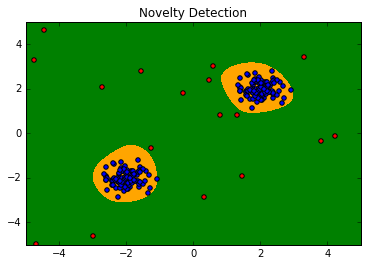

In [47]:
# Plot the decision grid
%sql drop table if exists Z_D;
%sql SELECT madlib.svm_predict('svm_out1', 'grid_points', 'index', 'Z_D');
Z_D = %sql SELECT decision_function from Z_D order by index
Z = np.array(Z_D)
Z = Z.reshape(xx.shape)

# Orange is not novel, green is novel
plt.title("Novelty Detection")
plt.contourf(xx, yy, Z, levels=[0, Z.max()], colors='orange')
plt.contourf(xx, yy, Z, levels=[Z.min(), 0], colors='green')
#plt.contourf(xx, yy, Z, levels=np.linspace(Z.min(), Z.max(), 7), cmap=plt.cm.Blues_r)
b1 = plt.scatter(X_train[:, 0], X_train[:, 1], c='blue')
c = plt.scatter(X_outliers[:, 0], X_outliers[:, 1], c='red')
plt.axis('tight')
plt.xlim((-5, 5))
plt.ylim((-5, 5))
plt.show()